In [30]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Material properties
E = 110e9  # Young's modulus in Pa (GPa to Pa)
nu = 0.33  # Poisson's ratio

# Define mesh parameters
L = 0.04  # Length in meters
H = 0.03  # Height in meters
m = 5  # Number of elements along length
n = 10  # Number of elements along height
c=1e6
num_nodes = (m + 1) * (n + 1)
num_elements = m * n

# Create node coordinates
x = np.linspace(0, L, m + 1)
y = np.linspace(0, H, n + 1)
X, Y = np.meshgrid(x, y)
nodes = np.vstack([X.flatten(), Y.flatten()]).T

# Element connectivity
elements = np.zeros((num_elements, 4), dtype=int)
for i in range(n):
    for j in range(m):
        node1 = i * (m + 1) + j
        node2 = node1 + 1
        node3 = node1 + (m + 1)
        node4 = node3 + 1
        elements[i * m + j, :] = [node1, node2, node4, node3]

In [15]:
# Function to compute shape functions and their derivatives for quadrilateral elements
def shape_functions(eta1, eta2):
    N = 0.25 * np.array([(1 - eta1) * (1 - eta2), 
                         (1 + eta1) * (1 - eta2), 
                         (1 + eta1) * (1 + eta2), 
                         (1 - eta1) * (1 + eta2)])
    
    dN_deta1 = np.array([-0.25 * (1 - eta2), 
                       0.25 * (1 - eta2), 
                       0.25 * (1 + eta2), 
                       -0.25 * (1 + eta2)])
    
    dN_deta2 = np.array([-0.25 * (1 - eta1), 
                        -0.25 * (1 + eta1), 
                        0.25 * (1 + eta1), 
                        0.25 * (1 - eta1)])
    
    return N, dN_deta1, dN_deta2

# Function to compute element stiffness matrix
def element_stiffness(E, nu, node_coords):
    gauss_points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
    Ke = np.zeros((8, 8))

    for eta1 in gauss_points:
        for eta in gauss_points:
            N, dN_deta1, dN_deta2 = shape_functions(eta1, eta)
            J = np.vstack([dN_deta1, dN_deta2]) @ node_coords
            detJ = np.linalg.det(J)
            invJ = np.linalg.inv(J)
            dN_xy = invJ @ np.vstack([dN_deta1, dN_deta2])
            
            B = np.zeros((3, 8))
            B[0, 0::2] = dN_xy[0, :]
            B[1, 1::2] = dN_xy[1, :]
            B[2, 0::2] = dN_xy[1, :]
            B[2, 1::2] = dN_xy[0, :]
            
            D = (E / (1 - nu**2)) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]])
            
            Ke += B.T @ D @ B * detJ
    
    return Ke

In [16]:
# Function to compute element force vector due to traction using Gaussian quadrature
def element_force(c, t_max, node_coords):
    Fe = np.zeros(8)  
    t = c * t_max  
    gauss_points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])  
    gauss_weights = np.array([1, 1])  

    def shape_functions_edge(eta1):
        N3 = 0.5 * (1 - eta1)  
        N4 = 0.5 * (1 + eta1)  
        return np.array([N3, N4])
    
    for gp, w in zip(gauss_points, gauss_weights):
        N_edge = shape_functions_edge(gp)
        
        edge_length = np.linalg.norm(node_coords[3] - node_coords[2])
        
        Fe[5] += N_edge[0] * t * edge_length * w / 2  
        Fe[7] += N_edge[1] * t * edge_length * w / 2  
    
    return Fe
K = np.zeros((2 * num_nodes, 2 * num_nodes))

for elem in range(num_elements):
    element_nodes = elements[elem, :]
    node_coords = nodes[element_nodes, :]
    
    Ke = element_stiffness(E, nu, node_coords)
    
    
    for i in range(4):
        for j in range(4):
            K[2 * element_nodes[i]:2 * element_nodes[i] + 2, 2 * element_nodes[j]:2 * element_nodes[j] + 2] += Ke[2 * i:2 * i + 2, 2 * j:2 * j + 2]
        
# Apply boundary conditions and determine free DOFs.
fixed_dofs = []
for i in range(num_nodes):
    if nodes[i][1] == 0:  
        fixed_dofs.append(2*i + 1)  
    if nodes[i][0] == 0 and nodes[i][1] == 0:  
        fixed_dofs.append(2*i)  

free_dofs = np.setdiff1d(np.arange(2*num_nodes), fixed_dofs)

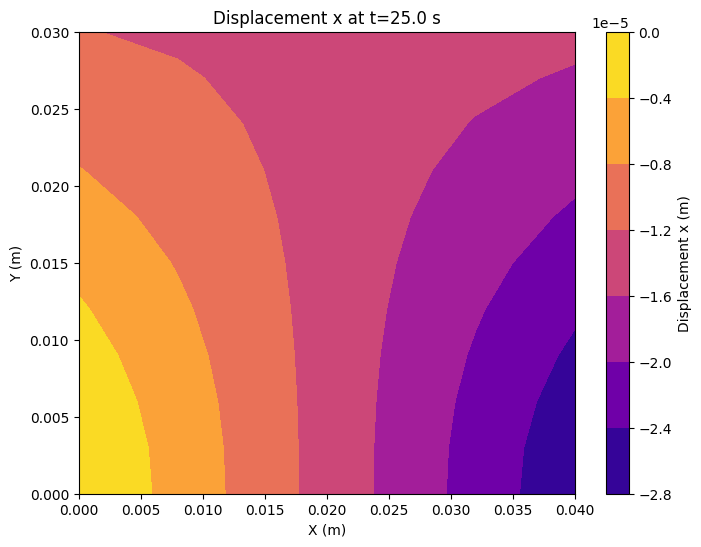

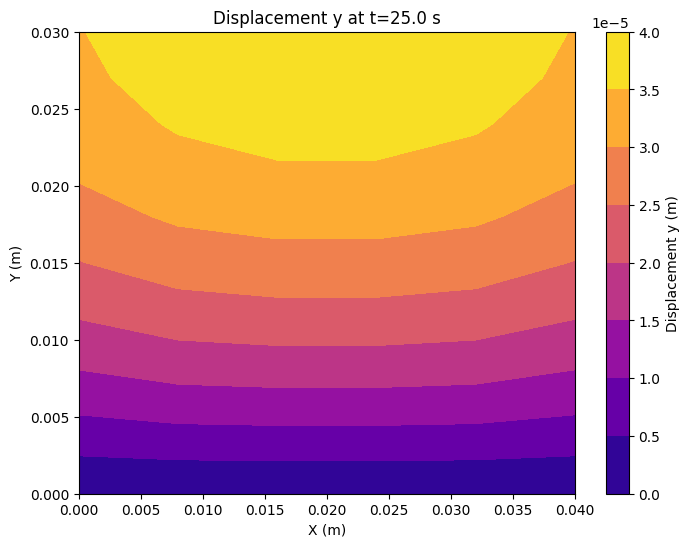

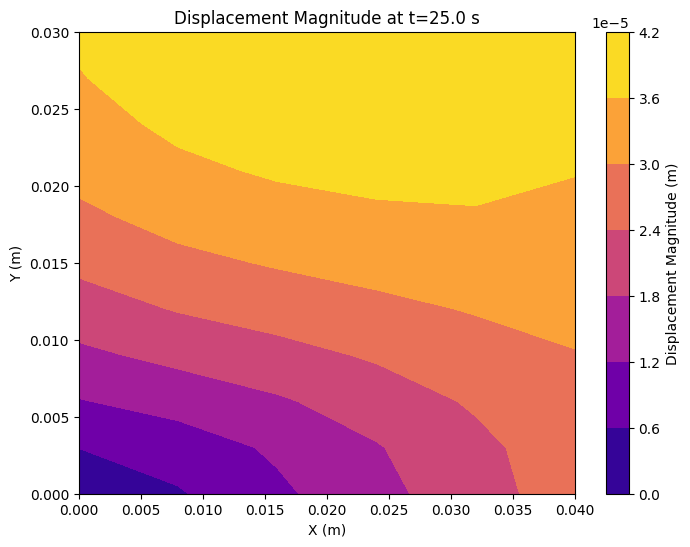

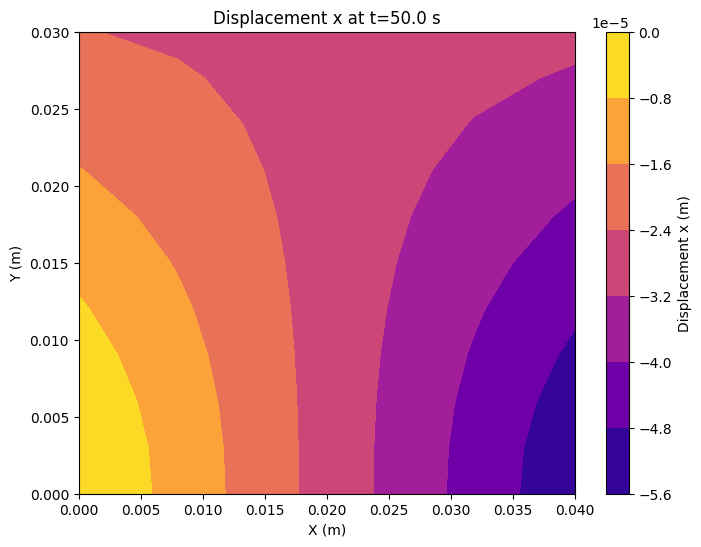

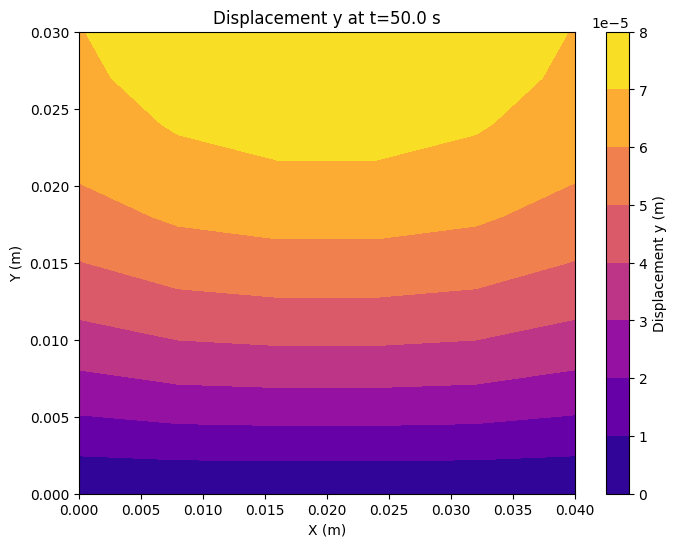

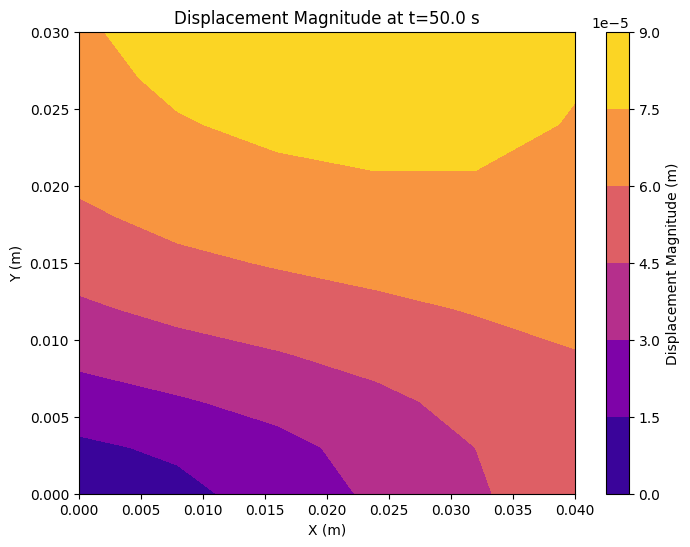

In [17]:
# Solve the system to get displacements U here...
# Assume that K is assembled and boundary conditions are applied...

t_values_c=[25 ,50]
for t in t_values_c:
    F=np.zeros(2*num_nodes)

    # Assemble the force vector F for current time instant
    for elem in range(num_elements):
        element_nodes=elements[elem]
        node_coords=nodes[element_nodes]
        
        Fe=element_force(c,t,node_coords)

        for i in range(4):
            F[2*element_nodes[i]:2*element_nodes[i]+2]+=Fe[2*i:2*i+2]

    U=np.zeros(2*num_nodes)
    U[free_dofs]=solve(K[np.ix_(free_dofs ,free_dofs)],F[free_dofs])
    T_50=U

    Ux=U[0::2].reshape(n+1,m+1)
    Uy=U[1::2].reshape(n+1,m+1)

   # Calculate displacement magnitude
    displacement_magnitude=np.sqrt(Ux**2+Uy**2)

   # Plot displacement magnitude at specified times.
    plt.figure(figsize=(8 ,6))
    plt.contourf(X,Y ,Ux,cmap='plasma')
    plt.colorbar(label='Displacement x (m)')
    plt.title(f'Displacement x at t={t:.1f} s')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.savefig(f'displacement_x_t={t}.png') # Save the plot as a static image
    plt.show()
    # Plot displacement magnitude at specified times.
    plt.figure(figsize=(8 ,6))
    plt.contourf(X,Y ,Uy,cmap='plasma')
    plt.colorbar(label='Displacement y (m)')
    plt.title(f'Displacement y at t={t:.1f} s')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.savefig(f'displacement_y={t}.png') # Save the plot as a static image
    plt.show()
    # Plot displacement magnitude at specified times.
    plt.figure(figsize=(8 ,6))
    plt.contourf(X,Y ,displacement_magnitude,cmap='plasma')
    plt.colorbar(label='Displacement Magnitude (m)')
    plt.title(f'Displacement Magnitude at t={t:.1f} s')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.savefig(f'displacement_magnitude_t={t}.png') # Save the plot as a static image
    plt.show()

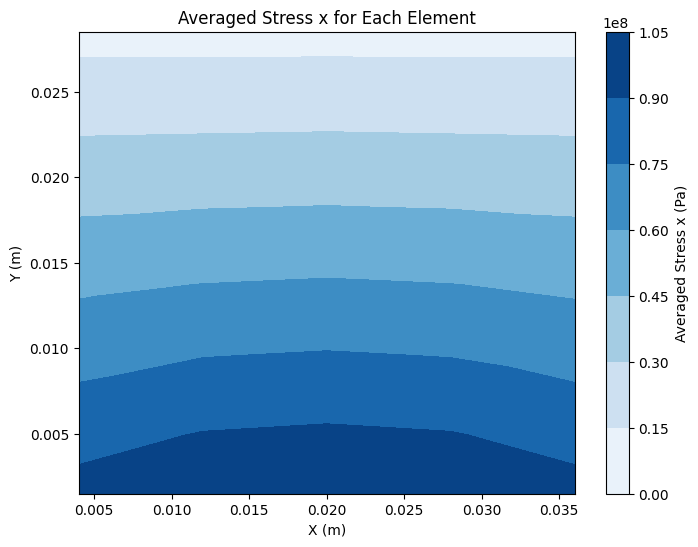

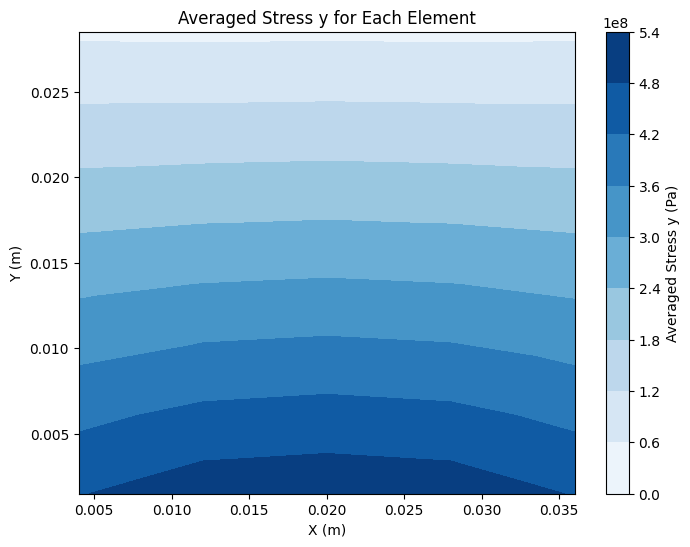

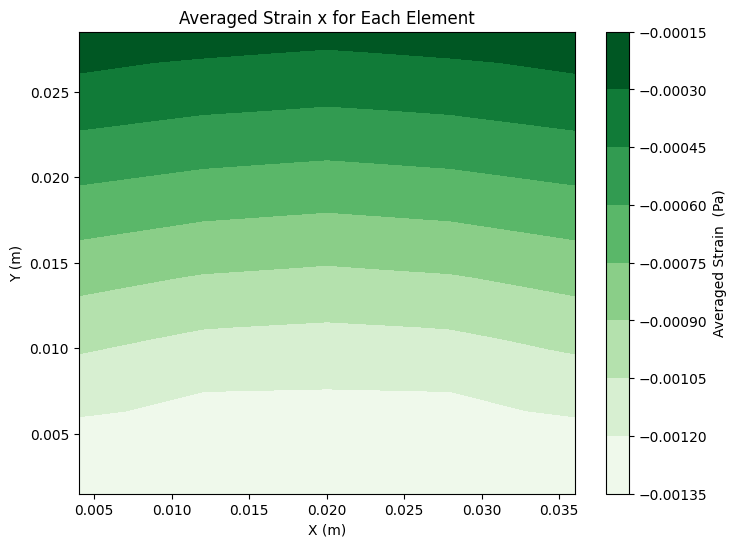

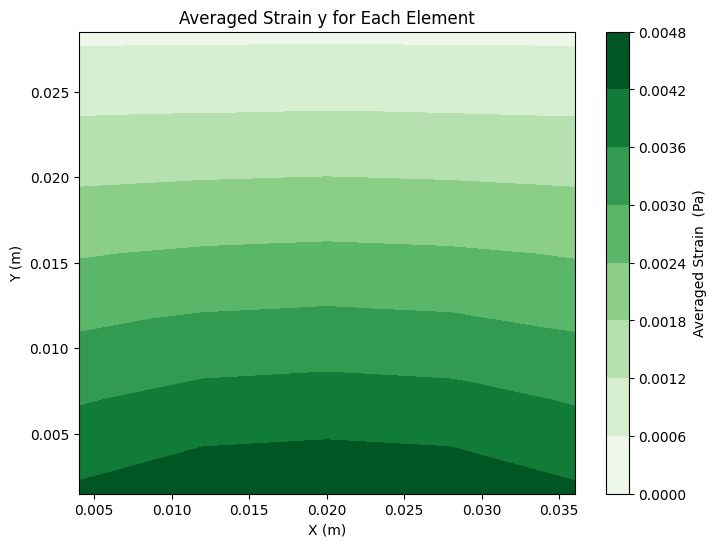

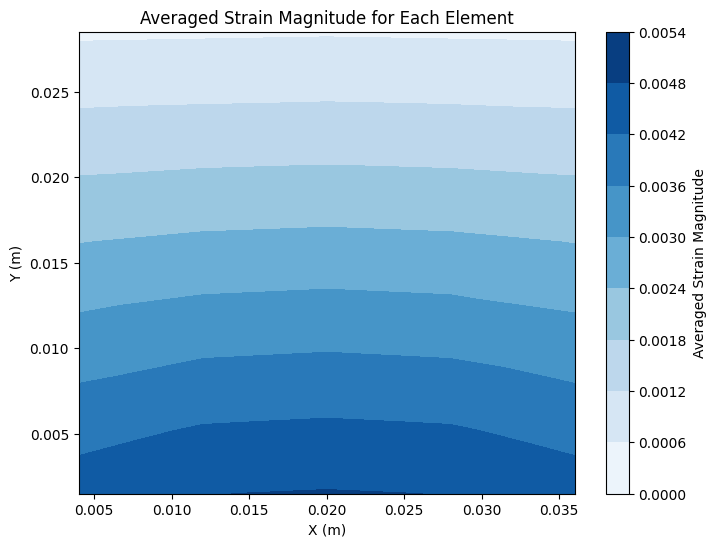

In [18]:


# Function to compute strain and stress for each element by averaging at the 4 nodes
def compute_element_average_strain_stress_node_avg(U, elements, nodes, E, nu):
    D = (E / (1 - nu**2)) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]])
    num_elements = len(elements)  # Automatically determine the number of elements
    avg_strains = np.zeros((num_elements, 3))  # 3 components of strain: exx, eyy, gxy
    avg_stresses = np.zeros((num_elements, 3))  # 3 components of stress: sxx, syy, txy

    # Loop over each element
    for elem in range(num_elements):
        element_nodes = elements[elem, :]
        node_coords = nodes[element_nodes, :]

        strain_elem = np.zeros(3)  # Average strain for the element
        stress_elem = np.zeros(3)  # Average stress for the element

        # Get the element displacement vector Ue (for the 4 nodes of the element)
        Ue = np.zeros(8)  # 4 nodes * 2 DOFs (Ux, Uy)
        for i in range(4):
            Ue[2 * i] = U[2 * element_nodes[i]]      # Ux for node i
            Ue[2 * i + 1] = U[2 * element_nodes[i] + 1]  # Uy for node i

        # Loop over each of the 4 nodes in the element
        for i in range(4):
            # Compute the shape function derivatives at the node's natural coordinates
            eta1, eta = shape_function_node_coords(i)  # Natural coordinates of the node i
            N, dN_deta1, dN_deta = shape_functions(eta1, eta)

            # Compute the Jacobian and its inverse
            J = np.vstack([dN_deta1, dN_deta]) @ node_coords
            invJ = np.linalg.inv(J)

            # Transform the shape function derivatives to the physical coordinates
            dN_xy = invJ @ np.vstack([dN_deta1, dN_deta])

            # Strain-displacement matrix B
            B = np.zeros((3, 8))
            B[0, 0::2] = dN_xy[0, :]  # dN/dx
            B[1, 1::2] = dN_xy[1, :]  # dN/dy
            B[2, 0::2] = dN_xy[1, :]  # dN/dy
            B[2, 1::2] = dN_xy[0, :]  # dN/dx

            # Compute the strain at the current node
            strain = B @ Ue  # Use the full element displacement vector Ue

            # Compute the stress at the current node using Hooke's law
            stress = D @ strain

            # Accumulate strain and stress values
            strain_elem += strain
            stress_elem += stress

        # Average strain and stress over the 4 nodes
        strain_elem /= 4
        stress_elem /= 4

        # Store the averaged values
        avg_strains[elem, :] = strain_elem
        avg_stresses[elem, :] = stress_elem

    return avg_strains, avg_stresses

# Function to get natural coordinates for each node (corners) in a quadrilateral element
def shape_function_node_coords(node_index):
    if node_index == 0:
        return (-1, -1)  # Node 1: bottom-left corner
    elif node_index == 1:
        return (1, -1)   # Node 2: bottom-right corner
    elif node_index == 2:
        return (1, 1)    # Node 3: top-right corner
    elif node_index == 3:
        return (-1, 1)   # Node 4: top-left corner

# Ensure shape_functions is defined for both shape functions and derivatives
def shape_functions(eta1, eta):
    N = 0.25 * np.array([(1 - eta1) * (1 - eta), (1 + eta1) * (1 - eta), (1 + eta1) * (1 + eta), (1 - eta1) * (1 + eta)])
    dN_deta1 = np.array([-0.25 * (1 - eta), 0.25 * (1 - eta), 0.25 * (1 + eta), -0.25 * (1 + eta)])
    dN_deta = np.array([-0.25 * (1 - eta1), -0.25 * (1 + eta1), 0.25 * (1 + eta1), 0.25 * (1 - eta1)])
    return N, dN_deta1, dN_deta

# Compute the average strain and stress for each element
avg_strains, avg_stresses = compute_element_average_strain_stress_node_avg(U, elements, nodes, E, nu)

# Calculate stress and strain magnitudes
e_xx=np.array(avg_strains[:, 0])
e_yy=np.array(avg_strains[:, 1])
e_xy=np.array(avg_strains[:, 2])
s_xx=np.array(avg_stresses[:, 1]/5+avg_strains[:, 0])
s_xy=np.array(avg_stresses[:, 2])
s_yy=np.array(avg_stresses[:, 1])
strain_magnitude = np.sqrt(avg_strains[:, 0]**2 + avg_strains[:, 1]**2 + avg_strains[:, 2]**2)
stress_magnitude = np.sqrt(avg_stresses[:, 0]**2 + avg_stresses[:, 1]**2 + avg_stresses[:, 2]**2)

# Compute element centroids for plotting
element_centroids = np.zeros((len(elements), 2))
for elem in range(len(elements)):
    element_nodes = elements[elem, :]
    node_coords = nodes[element_nodes, :]
    centroid_x = np.mean(node_coords[:, 0])
    centroid_y = np.mean(node_coords[:, 1])
    element_centroids[elem, :] = [centroid_x, centroid_y]

# Extract centroid coordinates
centroid_x = element_centroids[:, 0]
centroid_y = element_centroids[:, 1]

plt.figure(figsize=(8, 6))
plt.tricontourf(centroid_x, centroid_y, s_xx, cmap='Blues')
plt.colorbar(label='Averaged Stress x (Pa)')
plt.title('Averaged Stress x for Each Element')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig(f'Averaged Stress x.png') # Save the plot as a static image
plt.show()

plt.figure(figsize=(8, 6))
plt.tricontourf(centroid_x, centroid_y, s_yy, cmap='Blues')
plt.colorbar(label='Averaged Stress y (Pa)')
plt.title('Averaged Stress y for Each Element')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig(f'Averaged Stress y.png') # Save the plot as a static image
plt.show()




# Plot averaged stress magnitude for each element
plt.figure(figsize=(8, 6))
plt.tricontourf(centroid_x, centroid_y, e_xx, cmap='Greens')
plt.colorbar(label='Averaged Strain  (Pa)')
plt.title('Averaged Strain x for Each Element')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig(f'Averaged Strain x.png') # Save the plot as a static image
plt.show()

plt.figure(figsize=(8, 6))
plt.tricontourf(centroid_x, centroid_y, e_yy, cmap='Greens')
plt.colorbar(label='Averaged Strain  (Pa)')
plt.title('Averaged Strain y for Each Element')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig(f'Averaged Strain y.png') # Save the plot as a static image
plt.show()



# Plot averaged strain magnitude for each element
plt.figure(figsize=(8, 6))
plt.tricontourf(centroid_x, centroid_y, strain_magnitude, cmap='Blues')
plt.colorbar(label='Averaged Strain Magnitude')
plt.title('Averaged Strain Magnitude for Each Element')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig(f'Averaged Strain magnitude.png') # Save the plot as a static image
plt.show()


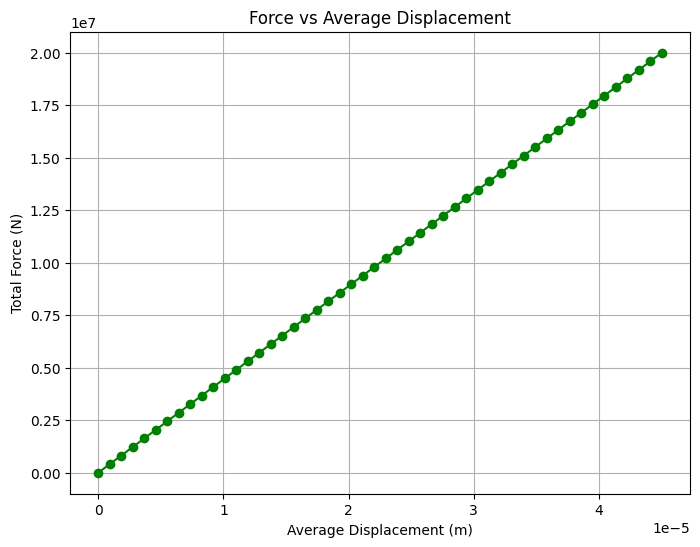

In [19]:

t_values = np.linspace(0, 50, 50)  # Time values for different instants

# Solve for different time instants and compute average displacement
average_displacements = []
total_forces = []

for t in t_values:
    F = np.zeros(2 * num_nodes)
    
    # Assemble the force vector F for current time instant
    for elem in range(num_elements):
        element_nodes = elements[elem, :]
        node_coords = nodes[element_nodes, :]
        
        Fe = element_force(c, t, node_coords)
        
        for i in range(4):
            F[2 * element_nodes[i]:2 * element_nodes[i] + 2] += Fe[2 * i:2 * i + 2]
    
    # Solve for displacements
    U = np.zeros(2 * num_nodes)
    U[free_dofs] = solve(K[np.ix_(free_dofs, free_dofs)], F[free_dofs])
    
    # Calculate the average displacement (magnitude) of the mesh
    Ux = U[0::2]  # Displacement in x-direction
    Uy = U[1::2]  # Displacement in y-direction
    #THE 10 TH ROW REPRESENTS THE TOP EDGE THE AVERAGE DISPLACEMENT OF THEM ARE CONSISDERD 
    displacement_magnitude = np.sqrt(Ux[n]**2 + Uy[n]**2)
    avg_displacement = np.mean(displacement_magnitude)
    
    average_displacements.append(avg_displacement)
    
    # Compute total applied force (sum of the nodal forces in the y-direction)
    total_force = np.sum(F[1::2])  # Sum of forces in y-direction
    total_forces.append(total_force)

# Plot force vs average displacement
plt.figure(figsize=(8, 6))
plt.plot(average_displacements, total_forces, marker='o', linestyle='-', color='g')
plt.xlabel('Average Displacement (m)')
plt.ylabel('Total Force (N)')
plt.title('Force vs Average Displacement')
plt.grid(True)
plt.savefig(f'Force vs Average Displacement.png')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_15540\2077061197.py:127: RuntimeWarning: invalid value encountered in scalar divide
  avg_slope.append(avg_stress/avg_strain)


Youngs Modulus: 127500637175.1166


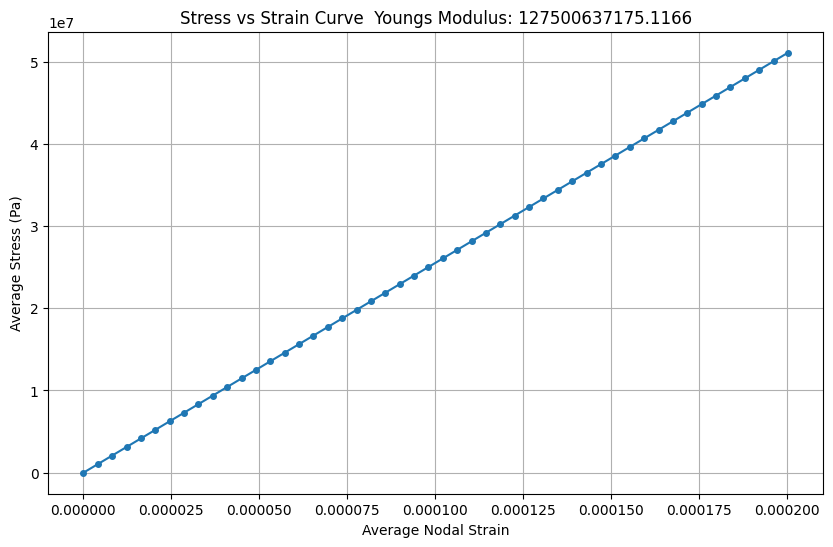

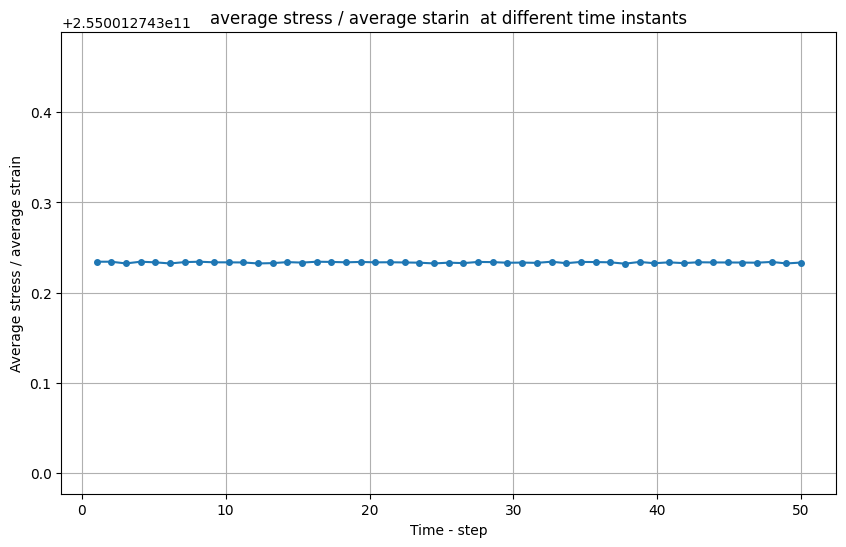

In [29]:
# Initialize lists to store average stress and strain values
average_strains = []
average_stresses = []
avg_slope=[]
points = np.linspace(0, 50, 50)

# Define the nodes we want to track (nodes 61-66)
tracked_nodes = np.arange(61, 67)
gauss_points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])

# Solve for different time instants
for t in points:
    F = np.zeros(2 * num_nodes)
    
    # Assemble the force vector F for current time instant
    for elem in range(num_elements):
        element_nodes = elements[elem, :]
        node_coords = nodes[element_nodes, :]
        
        Fe = element_force(c, t, node_coords)
        
        for i in range(4):
            F[2 * element_nodes[i]:2 * element_nodes[i] + 2] += Fe[2 * i:2 * i + 2]
    
    # Solve for displacements
    U = np.zeros(2 * num_nodes)
    U[free_dofs] = solve(K[np.ix_(free_dofs, free_dofs)], F[free_dofs])
    
    # Calculate nodal strains for tracked nodes
    total_strain = 0
    
    for node in tracked_nodes:
        # Get the displacement of the current node
        node_disp_x = U[2 * node-2]
        node_disp_y = U[2 * node-1]
        
        # Find elements containing this node
        node_elements = [elem for elem in range(num_elements) if node in elements[elem, :]]
        node_strain = 0
        
        for elem in node_elements:
            element_nodes = elements[elem, :]
            node_coords = nodes[element_nodes, :]
            node_idx = np.where(element_nodes == node)[0][0]
            
            # Get local coordinates for the node
            if node_idx == 0:   eta1, eta = -1, -1
            elif node_idx == 1: eta1, eta = 1, -1
            elif node_idx == 2: eta1, eta = 1, 1
            elif node_idx == 3: eta1, eta = -1, 1
            
            # Calculate strain at node position
            N, dN_deta1, dN_deta = shape_functions(eta1, eta)
            J = np.vstack([dN_deta1, dN_deta]) @ node_coords
            invJ = np.linalg.inv(J)
            dN_xy = invJ @ np.vstack([dN_deta1, dN_deta])
            
            # Get element displacements
            Ue = np.zeros(8)
            for i in range(4):
                Ue[2*i:2*i + 2] = U[2*element_nodes[i]:2*element_nodes[i] + 2]
            
            # Form B matrix
            B = np.zeros((3, 8))
            B[0, 0::2] = dN_xy[0, :]
            B[1, 1::2] = dN_xy[1, :]
            B[2, 0::2] = dN_xy[1, :]
            B[2, 1::2] = dN_xy[0, :]
            
            # Calculate strain
            strain = B @ Ue
            node_strain += np.sqrt(strain[0]**2 + strain[1]**2+strain[2]**2)
        
        # Average strain for this node
        total_strain += node_strain / 4
    
    # Average strain across all tracked nodes
    avg_strain = total_strain / 6
    
    # Calculate average stress using Gaussian quadrature
    total_stress = 0
    num_gaussian_points = 0
    
    # Find elements connected to tracked nodes
    relevant_elements = set()
    for node in tracked_nodes:
        relevant_elements.update([elem for elem in range(num_elements) if node in elements[elem, :]])
    
    # Calculate stress using Gaussian quadrature
    for elem in relevant_elements:
        element_nodes = elements[elem, :]
        node_coords = nodes[element_nodes, :]
        Ue = np.zeros(8)
        
        for i in range(4):
            Ue[2*i:2*i + 2] = U[2*element_nodes[i]:2*element_nodes[i] + 2]
        
        # Gaussian quadrature
        for eta1 in gauss_points:
            for eta in gauss_points:
                num_gaussian_points += 1
                
                N, dN_deta1, dN_deta = shape_functions(eta1, eta)
                J = np.vstack([dN_deta1, dN_deta]) @ node_coords
                invJ = np.linalg.inv(J)
                dN_xy = invJ @ np.vstack([dN_deta1, dN_deta])
                
                B = np.zeros((3, 8))
                B[0, 0::2] = dN_xy[0, :]
                B[1, 1::2] = dN_xy[1, :]
                B[2, 0::2] = dN_xy[1, :]
                B[2, 1::2] = dN_xy[0, :]
                
                # Calculate strain at Gauss point
                strain = B @ Ue
                
                # Calculate stress at Gauss point
                D = (E / (1 - nu**2)) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]])
                stress = D @ strain
                total_stress += np.sqrt(stress[0]**2 + stress[1]**2+stress[2]**2)
    
    # Average stress across all Gauss points
    avg_stress = total_stress / num_gaussian_points
    
    average_strains.append(avg_strain)
    average_stresses.append(avg_stress)
    avg_slope.append(avg_stress/avg_strain)


 
def get_slope_polyfit(x, y):
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]/2
    intercept = coefficients[1]
    return slope, intercept
a,b=get_slope_polyfit(average_strains,average_stresses)
print("Youngs Modulus: "+str(a))
# Plot the stress vs strain curve
plt.figure(figsize=(10, 6))
plt.plot(average_strains, average_stresses, marker='o', markersize=4)
plt.xlabel('Average Nodal Strain')
plt.ylabel('Average Stress (Pa)')
plt.title('Stress vs Strain Curve  '+'Youngs Modulus: '+str(a))
plt.savefig(f'Stress vs Strain Curve.png')
plt.grid(True)
plt.show()

# Plot the stress vs strain curve
plt.figure(figsize=(10, 6))
plt.plot(points, avg_slope, marker='o', markersize=4)
plt.xlabel('Time - step')
plt.ylabel('Average stress / average strain')
plt.title('average stress / average starin  at different time instants')
plt.savefig(f'slope stress strain with time')
plt.grid(True)
plt.show()



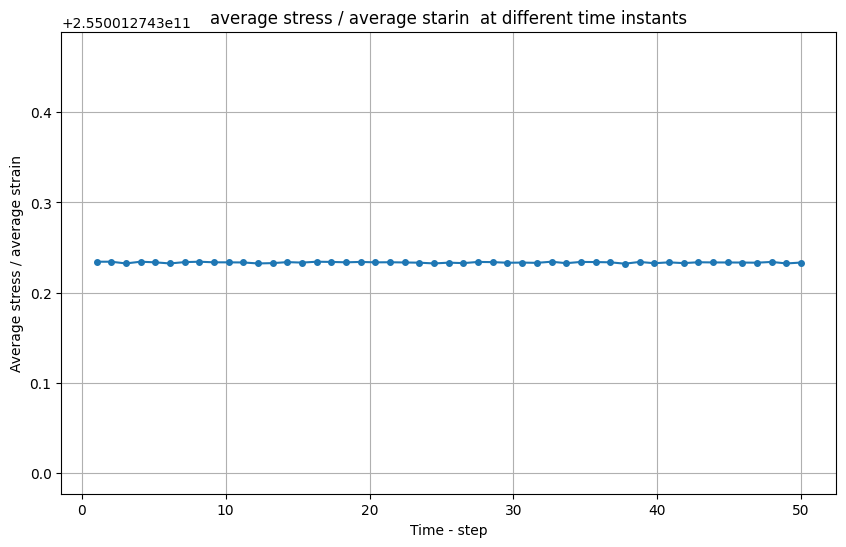